In [107]:
import pandas as pd
import random
import os

In [22]:
from dotenv import load_dotenv

In [24]:
load_dotenv(dotenv_path='/Users/daniel/OAN/SID/.env')

True

In [1]:
# import the necessary packages
from config import esri_retinanet_config as config

In [14]:
#from shutil import copyfile

In [11]:
from imutils import paths

In [39]:
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
from oauth2client import file,client, tools
from googleapiclient import discovery
from httplib2 import Http
## CONECTION TO DRIVE

SCOPES = ['https://www.googleapis.com/auth/drive'
        ]
store = file.Storage('/Users/daniel/OAN/credentials/storage.json')
creds = store.get()
if not creds or creds.invalid:
    flow = client.flow_from_clientsecrets('/Users/daniel/OAN/credentials/credentials.json', SCOPES)
    creds = tools.run_flow(flow, store)
drive_service = discovery.build('drive', 'v3', http=creds.authorize(Http()))

In [63]:
import numpy as np
from scipy.spatial import ConvexHull

def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    from scipy.ndimage.interpolation import rotate
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T
#     rotations = np.vstack([
#         np.cos(angles),
#         -np.sin(angles),
#         np.sin(angles),
#         np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

In [3]:
annot_path = config.ANNOT_PATH
annot_path

'dataset/annotations'

In [5]:
images_path = config.IMAGES_PATH
images_path

'dataset/images'

In [6]:
train_csv = config.TRAIN_CSV
train_csv

'dataset/train.csv'

In [7]:
test_csv = config.TEST_CSV
test_csv

'dataset/test.csv'

In [9]:
classes_csv = config.CLASSES_CSV
classes_csv

'dataset/classes.csv'

In [54]:
train_test_split = config.TRAIN_TEST_SPLIT*0.82
train_test_split

0.82

In [15]:
imageSource = list(paths.list_files('/Users/daniel/OAN/SID/poc/osm'))

In [25]:
images = [im for im in imageSource if 'ss' not in im and '.png' in im]

In [35]:
vil_name = [im.split('/')[-1].split('.')[0] for im in images]

In [27]:
img_info = pd.read_gbq('SELECT * FROM sidhouses.osm_data.image_ds_info')

In [29]:
len(img_info)

52

In [41]:
img_info.head()

,drive_id,village_name,path,lat_0,lon_0,deg_per_px_lat,deg_per_px_lon,n_houses,layer
0,1ERUqn0IWwczeIWYqkTJhv61XOVB5IExf,ALAFIAROU,/Users/daniel/OAN/SID/poc/osm/ALAFIAROU.png,10.068964,3.07710,0.000005,0.000005,10,bing
1,1iRSSNT0StWUtXJqt8IMj_OUmp1sokQil,TAKOU GANDO,/Users/daniel/OAN/SID/poc/osm/TAKOU GANDO.png,9.860075,3.22100,0.000005,0.000005,19,bing
2,1JhDdg8O_fosVOdn6szTA3mMPmg10InAp,PERANGOU BAGRI - GBÈRANKOU,/Users/daniel/OAN/SID/poc/osm/PERANGOU BAGRI -...,10.120093,3.43628,0.000005,0.000005,53,bing
3,1oP0XKEsZqgwdSWrswPucb6MoXxDbNi8f,KPARISSEROU PEULH,/Users/daniel/OAN/SID/poc/osm/KPARISSEROU PEUL...,9.952434,3.14307,0.000005,0.000005,7,esri
4,1__sch8bmeRnaYZzcZiLIDxbrHiGzZYsZ,MOUSSOURE,/Users/daniel/OAN/SID/poc/osm/MOUSSOURE.png,10.055894,3.04107,0.000005,0.000005,39,esri


In [48]:
for drive_id in img_info['drive_id'].to_list():
    file_data = drive_service.files().get_media(fileId=drive_id).execute()
    file = open(images_path+'/'+drive_id+'.png','wb')
    file.write(file_data)
    file.close()

In [31]:
len(img_info['village_name'].unique())

42

In [37]:
len(set(vil_name)-set(img_info['village_name'].unique()))

8

In [38]:
set(vil_name)-set(img_info['village_name'].unique())

{'BOUÉGOUROU',
 'GANDO BENIN',
 'GBABIRÉ',
 'GONGUÉ KPAROU',
 'KPEBOURABOU',
 'SONWORE 1',
 'SUYA',
 'ouroumonsi peulh'}

In [ ]:
##¿Copy images without anotations?
#copyfile(src, dst)

In [55]:
# grab all image paths then construct the training and testing split
imagePaths = list(paths.list_files(images_path))
random.shuffle(imagePaths)
i = int(len(imagePaths) * train_test_split)
trainImagePaths = imagePaths[:i]
testImagePaths = imagePaths[i:]

In [57]:
# create the list of datasets to build
dataset = [ ("train", trainImagePaths, train_csv),
            ("test", testImagePaths, test_csv)]

In [61]:
e= pd.read_gbq()

In [62]:
e.head()

,drive_id,id,house,lat_px,lon_px
0,1HoYJjr09ARcNXW2R6M9fMDNlnR4BERO8,832662584,"[[861.4804972529016, 315.99332622540544], [875...",323,869
1,1HoYJjr09ARcNXW2R6M9fMDNlnR4BERO8,832662585,"[[694.193076694044, 580.486603484584], [721.11...",585,709
2,1HoYJjr09ARcNXW2R6M9fMDNlnR4BERO8,832662586,"[[787.8658300156424, 549.7628281485813], [805....",558,796
3,1HoYJjr09ARcNXW2R6M9fMDNlnR4BERO8,832662587,"[[743.723127554899, 502.3804438816593], [756.1...",510,750
4,1HoYJjr09ARcNXW2R6M9fMDNlnR4BERO8,832662588,"[[836.8925645899891, 545.2006409300535], [851....",554,844


## CONVERT TO BOUNDING BOX

In [ ]:
mabr = minimum_bounding_rectangle(np.array(geom))

In [67]:
import cv2
import matplotlib.pyplot as plt

In [80]:
im = cv2.imread(images_path+'/'+'1HoYJjr09ARcNXW2R6M9fMDNlnR4BERO8.png')

In [75]:
e['len'] = e['house'].apply(lambda x: len(eval(x)))

In [100]:
im = cv2.imread(images_path+'/'+'1HoYJjr09ARcNXW2R6M9fMDNlnR4BERO8.png')
hous = e[e['len']==11]['house'].values[0]
house = [[int(h[0]),int(h[1])] for h in eval(hous)]
vertices = np.array(house,dtype=np.int32)
pts = vertices.reshape((-1,1,2))
cv2.polylines(im,[pts],isClosed=True,color=(0,0,255),thickness=1)
print(house)
mbr_0 = minimum_bounding_rectangle(np.array(house))
mbr = [[int(h[0]),int(h[1])] for h in mbr_0]
print(mbr)
vertices = np.array(mbr,dtype=np.int32)
pts = vertices.reshape((-1,1,2))
a=cv2.polylines(im,[pts],isClosed=True,color=(255,0,0),thickness=1)


[[877, 503], [889, 503], [889, 527], [885, 527], [885, 534], [877, 534], [877, 527], [873, 527], [873, 516], [877, 516], [877, 503]]
[[889, 503], [873, 503], [873, 534], [889, 534]]


In [105]:
im.shape

(780, 1880, 3)

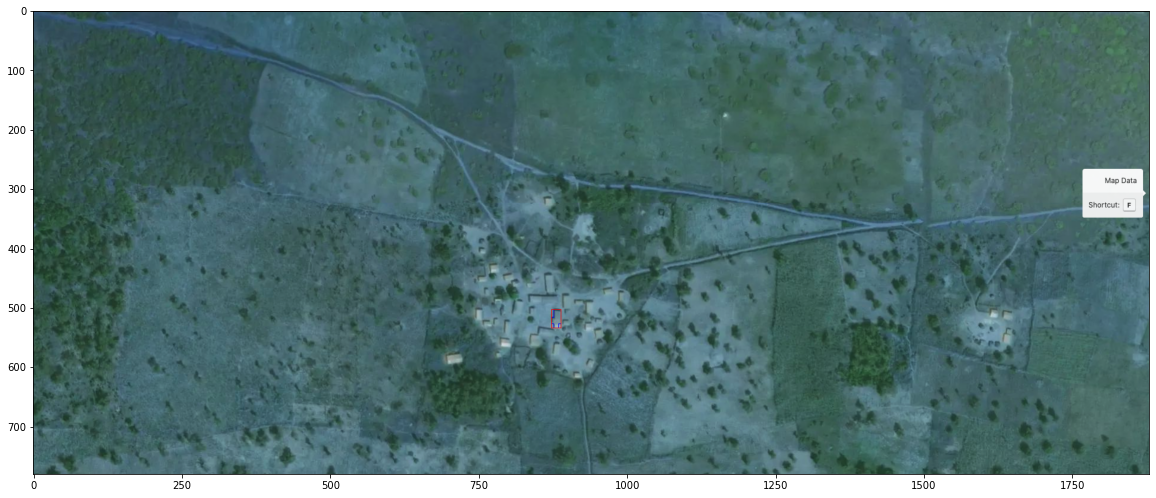

In [101]:
plt.figure(figsize=(20,10))
plt.imshow(im)

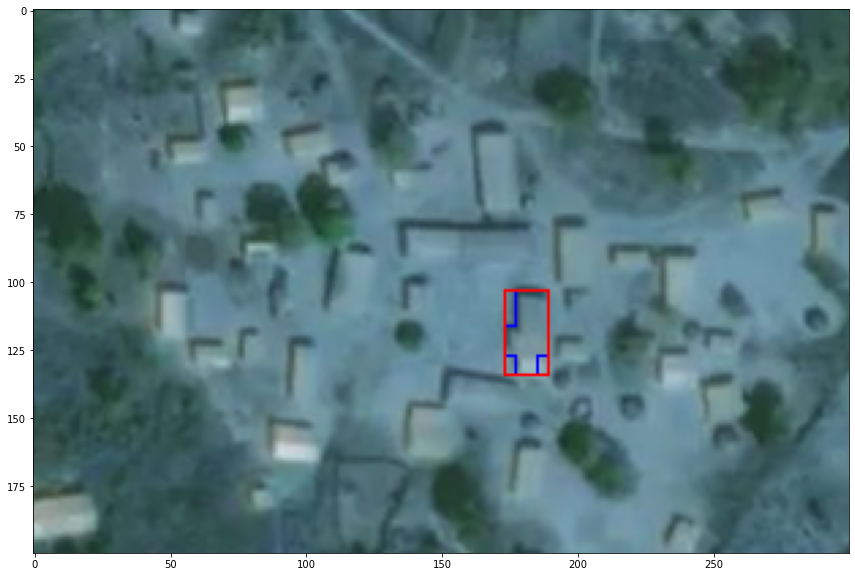

In [103]:
plt.figure(figsize=(20,10))
plt.imshow(im[400:600,700:1000,:])

In [108]:
CLASSES = set()

# loop over the datasets
for (dType, imagePaths, outputCSV) in dataset:
    # load the contents
    print ("[INFO] creating '{}' set...".format(dType))
    print ("[INFO] {} total images in '{}' set".format(len(imagePaths), dType))

    # open the output CSV file
    csv = open(outputCSV, "w")

    # loop over the image paths
    for imagePath in imagePaths:
        # build the corresponding annotation path
        fname = imagePath.split('/')[-1].split('.')[0]
        
        im = cv2.imread(imagePath)
        w = im.shape[1]
        h = im.shape[0]

        buildings = pd.read_gbq('''SELECT * 
                                   FROM sidhouses.output_data.image_ds 
                                   WHERE drive_id = '''+'"'+fname+'"')
        # loop over all object elements
        for hous in buildings['house'].to_list():
            house = [[int(h[0]),int(h[1])] for h in eval(hous)]
            mbr_0 = minimum_bounding_rectangle(np.array(house))
            mbr = [[int(h[0]),int(h[1])] for h in mbr_0]
            
            #extract the label and bounding box coordinates
            label = 'house'
            xMin = min([h[0] for h in mbr])
            yMin = min([h[1] for h in mbr])
            xMax = max([h[0] for h in mbr])
            yMax = max([h[1] for h in mbr])

            # truncate any bounding box coordinates that fall outside
            # the boundaries of the image
            xMin = max(0, xMin)
            yMin = max(0, yMin)
            xMax = min(w, xMax)
            yMax = min(h, yMax)

            # ignore the bounding boxes where the minimum values are larger
            # than the maximum values and vice-versa due to annotation errors
            if xMin >= xMax or yMin >= yMax:
                continue
            elif xMax <= xMin or yMax <= yMin:
                continue

            # write the image path, bb coordinates, label to the output CSV
            row = [os.path.abspath(imagePath),str(xMin), str(yMin), str(xMax),
                    str(yMax), str(label)]
            csv.write("{}\n".format(",".join(row)))

            # update the set of unique class labels
            CLASSES.add(label)

    # close the CSV file
    csv.close()

# write the classes to file
print("[INFO] writing classes...")
csv = open(classes_csv, "w")
rows = [",".join([c, str(i)]) for (i,c) in enumerate(CLASSES)]
csv.write("\n".join(rows))
csv.close()


[INFO] creating 'train' set...
[INFO] 42 total images in 'train' set
[INFO] creating 'test' set...
[INFO] 10 total images in 'test' set
[INFO] writing classes...
